<a href="https://colab.research.google.com/github/GastonRAraujo/Materia-Ap_Maq/blob/master/TP6/IMDB_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting IMDB Rating for Movies
The goal of this project is to build a model that predicts the IMDB rating score based on attributes as duration, actors or even titles. Take some time to understand the data, which movies have the highest score? Is there any relationship between the score and the cast? What about the movie director? More info about this data [here](https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset).

In [1]:
#imports
import numpy as np
import pandas as pd

#import viz
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from matplotlib import style
plt.style.use('seaborn')   #lo uso para cmabiar el background de las figuras porque uso dark mode

from sklearn.model_selection import train_test_split

In [2]:
imdb_data = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectIMDB/data/movie_metadata.csv")
imdb_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [3]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

Voy a quitar el link de la pelicula y el nombre porque no seran necesarios ademas de observar la cantidad de datos faltantes en cada categoría

In [4]:
imdb_data.drop(['movie_imdb_link', 'movie_title'], inplace=True, axis=1)

nulls = pd.isna(imdb_data).sum()

nulls

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

Antes de continuar voy a eliminar posibles duplicados

In [5]:
 size_antes = imdb_data.shape

#elimino duplicados
df = imdb_data.drop_duplicates(keep='first')

print('Se han eliminado {} duplicados'.format(size_antes[0]-df.shape[0]))


df = df.dropna().reset_index(drop=True)

Se han eliminado 45 duplicados


Me fijo que columnas tipo "object" poseen pocos valores unicos para utilizar OneHot Encoding o algun Encode similar

In [6]:
df.select_dtypes(include = 'object').agg(['nunique'])

,color,director_name,actor_2_name,genres,actor_1_name,actor_3_name,plot_keywords,language,country,content_rating
nunique,2,1659,2188,745,1428,2587,3656,34,45,12


Las columnas que poseen más de 1000 elementos únicos (a excepcion de plot_keywords y genres que deben ser tratados a parte) serán descartadas debido a la poca varianza que presentarían sus valores.

Veamos que valores posibles tenemos para "color", "language", "country" y "content_rating"


In [7]:
for a in ["color", "language", "country", "content_rating"]:
  dummy = pd.DataFrame(df[a])
  
  print("\nLa frecuencia de cada valor en la columna {}".format(dummy.value_counts()))


La frecuencia de cada valor en la columna color           
Color               3600
 Black and White     123
dtype: int64

La frecuencia de cada valor en la columna language  
English       3566
French          34
Spanish         23
Mandarin        14
German          10
Japanese        10
Italian          7
Cantonese        7
Portuguese       5
Hindi            5
Korean           5
Norwegian        4
Thai             3
Danish           3
Persian          3
Dutch            3
Indonesian       2
Dari             2
Aboriginal       2
Hungarian        1
Hebrew           1
Vietnamese       1
Kazakh           1
Filipino         1
Maya             1
Mongolian        1
None             1
Romanian         1
Czech            1
Russian          1
Bosnian          1
Aramaic          1
Arabic           1
Zulu             1
dtype: int64

La frecuencia de cada valor en la columna country       
USA               2961
UK                 313
France             101
Germany             79
Canada        

Para el caso de country y language vemos que una categoría posee una amplia diferencia con las demás. Por lo que podemos agruparlo como USA/NonUSA y English/NonEnglish. Al igual que anteriormente, voy a descartar Color por la poca varianza pero se podría utilizar Binary Encoding para transformar "color" en 0 o 1 segun sea "B&W" o "Color"

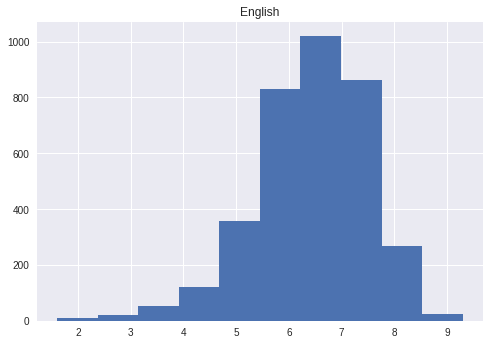

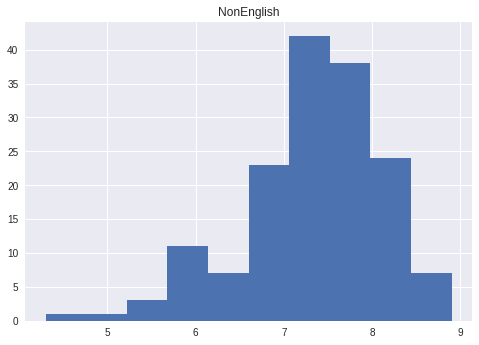

In [8]:
plt.style.use('seaborn')   #lo uso para cmabiar el background de las figuras porque uso dark mode


mask1 = [True if i == 'English' else False for i in df["language"].to_list() ]
mask2 = [False if i == 'English' else True for i in df["language"].to_list() ]

dummy = pd.DataFrame(df['imdb_score'].iloc[mask1])

dummy.hist()
plt.title('English')
plt.show()

dummy = pd.DataFrame(df['imdb_score'].iloc[mask2])

dummy.hist()
plt.title('NonEnglish')
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa108aa11d0>,
      dtype=object)

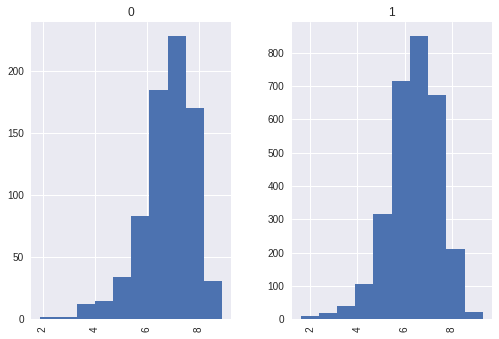

In [9]:
mask1 = [True if i == 'USA' else False for i in df["country"].to_list() ]
mask2 = [False if i == 'USA' else True for i in df["country"].to_list() ]

country2 = []
for i in df["country"].to_list():
  if i == 'USA':
    country2.append(1)
  else:
    country2.append(0)

df["country"] = country2

df.hist(column='imdb_score', by='country')

Investigando sobre los tipos de clasificaciones para películas, encontré que algunas son la misma categoría pero cuyo nombre a cambiado con el paso del tiempo, por lo que debo setear un solo criterio. [WIKIPEDIA](https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system)

El caso particular de 'Approved' y 'Passed' no aparecen en wikipedia y segun [esta pagina](https://movies.stackexchange.com/questions/65430/what-are-the-meanings-of-the-terms-passed-and-approved-with-regards-to-a-mov) se debe a películas muy antiguas, además de unificar 'Not Rated' con 'Unrated' ya que no poseo formar de clasificar segun los últimos criterios (y son la mayoría) por lo que usaré un marcador común a todas ('NotRated')



La frecuencia de cada valor en la columna 
R           1687
PG-13       1291
PG           566
G             87
NotRated      76
NC-17         16
Name: content_rating, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa108a14390>,
      dtype=object)

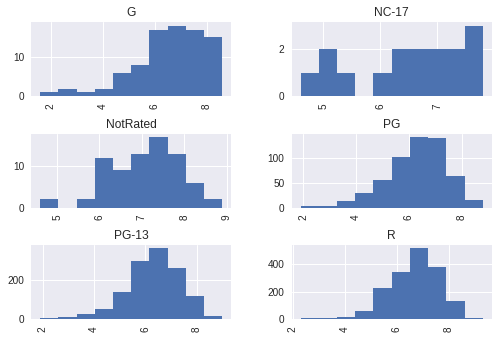

In [10]:
content_raiting2 = []
for i in df["content_rating"].to_list():
  if i == 'M' or i == 'GP':
    content_raiting2.append('PG')
  elif i == 'X':
    content_raiting2.append('NC-17')
  elif i == 'Approved' or i == 'Passed' or i == 'Unrated' or i == 'Not Rated':
    content_raiting2.append('NotRated')
  else:
    content_raiting2.append(i)

df["content_rating"] = content_raiting2

print("La frecuencia de cada valor en la columna \n{}".format(df["content_rating"].value_counts()))

df.hist(column='imdb_score', by='content_rating')

Para utilizar un RandomForest debo poder convertir mis datos a float32 por lo que agruparía PG, PG-13 y R debido a las distribuciones similares, pero esto dejaría solo 176 datos en la otra categoría por lo que no lo incluiré

Ahora analizo el caso de generos

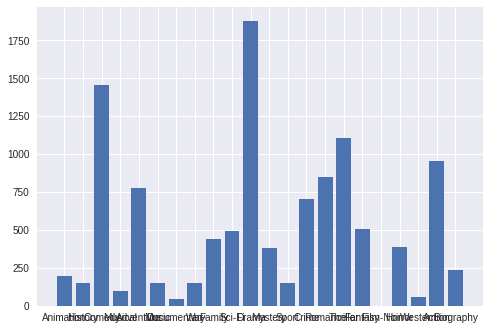

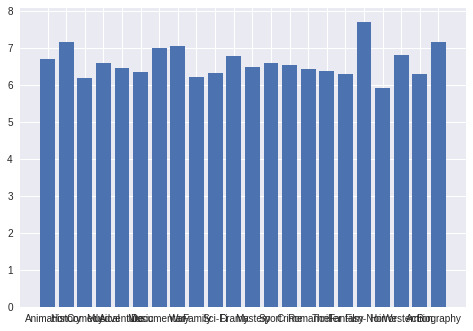

In [11]:
lista = df['genres'].to_list()

generos = [i.split('|') for i in lista]
df['genres'] = generos

flat_generos = set([item for sublist in generos for item in sublist])

genero_data = {i: [] for i in flat_generos}
flat_generos = {i : 0 for i in flat_generos}

for j, film_genre in enumerate(df['genres']):
 for i in film_genre:
   flat_generos[i] += 1
   genero_data[i].append(df['imdb_score'].iloc[j])

mean_score_genero = {i : 0 for i in flat_generos}

for key in genero_data:
  mean_score_genero[key] = sum(genero_data[key])/len(genero_data[key])

plt.bar(flat_generos.keys(), flat_generos.values())
plt.show()


plt.bar(mean_score_genero.keys(), mean_score_genero.values())
plt.show()

Vemos que hay generos que aparecen más frecuente que otros pero la media de todos es muy similar por lo que no lo tendremos en cuenta. 

Se realiza un analisis similar para plot_keywords

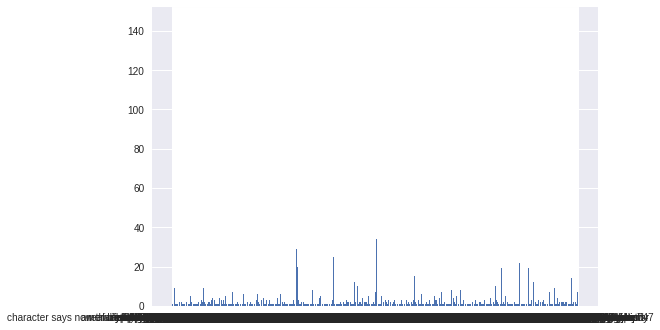

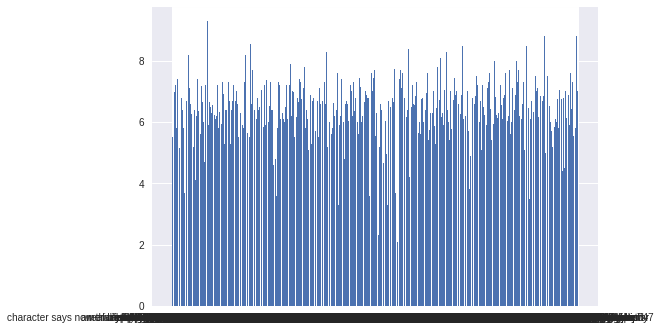

In [12]:
lista = df['plot_keywords'].to_list()

plot_keywords = [i.split('|') for i in lista]
df['plot_keywords'] = plot_keywords

flat_keywords = set([item for sublist in plot_keywords for item in sublist])

keywords_data = {i: [] for i in flat_keywords}
flat_keywords = {i : 0 for i in flat_keywords}

for j, film_keywords in enumerate(df['plot_keywords']):
 for i in film_keywords:
   flat_keywords[i] += 1
   keywords_data[i].append(df['imdb_score'].iloc[j])

mean_score_keywords = {i : 0 for i in flat_keywords}

for key in keywords_data:
  mean_score_keywords[key] = sum(keywords_data[key])/len(keywords_data[key])

plt.bar(flat_keywords.keys(), flat_keywords.values())
plt.show()


plt.bar(mean_score_keywords.keys(), mean_score_keywords.values())
plt.show()

"plot_keywords" individueales es 6726
con frecuencia mayor a 20 es     112


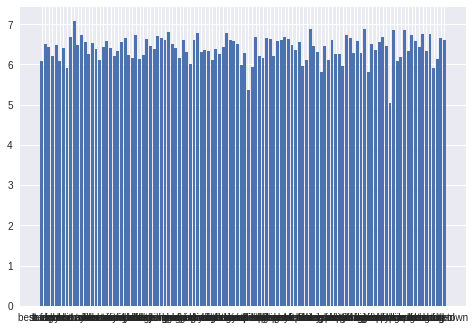

In [13]:
newKeys = []
for i in flat_keywords:
  if flat_keywords[i]>20:
    newKeys.append(i)

print('"plot_keywords" individueales es', len(flat_keywords))
print('con frecuencia mayor a 20 es    ', len(newKeys))

new_mean_score_keywords = { your_key: mean_score_keywords[your_key] for your_key in newKeys }

plt.bar(new_mean_score_keywords.keys(), new_mean_score_keywords.values())
plt.show()

Viendo los últimos dos histograma parecería interesante utilizar esta categoría pero la complejidad de manipular listas en columnas y el hecho de que la vasta mayoría no aparezca ni 20 veces provoca que decida no utilizarlo.

In [14]:
drops = ['director_name',	'actor_2_name', 'actor_1_name', 'actor_3_name', 'color', 'language', 'genres', 'plot_keywords', 'content_rating']
df.drop(drops, inplace=True, axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_critic_for_reviews     3723 non-null   float64
 1   duration                   3723 non-null   float64
 2   director_facebook_likes    3723 non-null   float64
 3   actor_3_facebook_likes     3723 non-null   float64
 4   actor_1_facebook_likes     3723 non-null   float64
 5   gross                      3723 non-null   float64
 6   num_voted_users            3723 non-null   int64  
 7   cast_total_facebook_likes  3723 non-null   int64  
 8   facenumber_in_poster       3723 non-null   float64
 9   num_user_for_reviews       3723 non-null   float64
 10  country                    3723 non-null   int64  
 11  budget                     3723 non-null   float64
 12  title_year                 3723 non-null   float64
 13  actor_2_facebook_likes     3723 non-null   float

Nos hemos quedado solo con 2 categorías tipo "object", veamos que sucede con las numéricas:

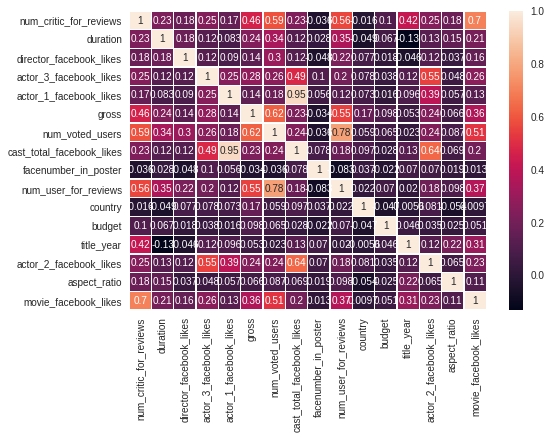

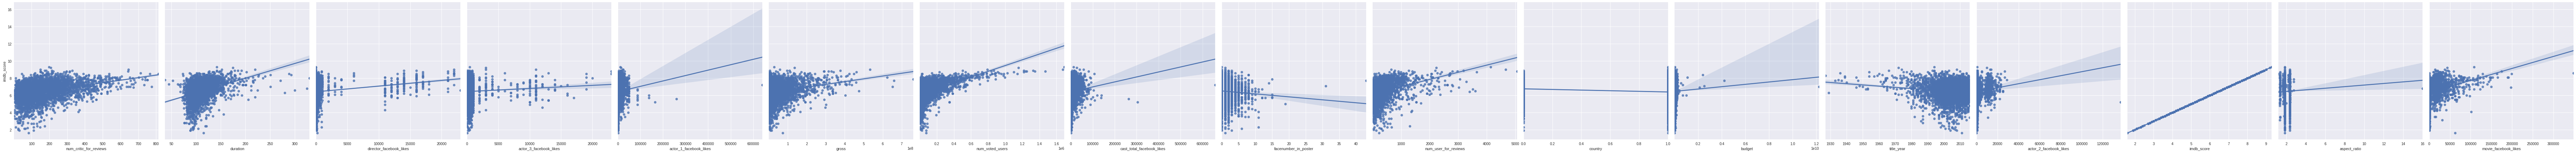

In [16]:
sns.heatmap(df.loc[:, df.columns != 'imdb_score'].corr(), linewidths=.3, annot=True)
sns.pairplot(df, y_vars='imdb_score',  height=6, aspect=1., diag_kind = None, kind='reg')

Del heatmap vemos una relacion entre los likes de los actores y los likes totales del cast (lo cual tiene sentido) por lo que me quedaré con este último. Al igual que con 'num_user_for_reviews' y 'num_voted_users'

Podemos observar una clara no linealidad entre los parámetros y el score obtenido ademas de una prescencia de outliers

In [17]:
drops = ['num_user_for_reviews', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']
df.drop(drops, inplace=True, axis=1)

Antes de continuar exploremos la importancia de cada columna para así poder reducir la dimencionalidad de nuestro modelo.

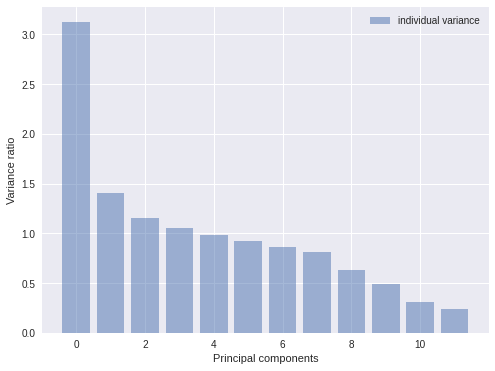

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

X_features = df.loc[:, df.columns != 'imdb_score']
X_features = X_features.select_dtypes(exclude='object')

scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

pca = PCA()
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(12), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

A partir del codigo encontrado [aquí](https://stackabuse.com/dimensionality-reduction-in-python-with-scikit-learn/#:~:text=The%20primary%20algorithms%20used%20to,into%20the%20machine%20learning%20classifier.) realice un plot de las columnas con mayor varianza (donde primero debí re-escalar mis datos). Decidí utilizar 6 dimensiones "numéricas"


In [19]:
pca2 = PCA(n_components=9)
pca2.fit(X_features)
X_num = pca2.transform(X_features)

print("X_num.shape = ", X_num.shape)

X_num.shape =  (3723, 9)


In [20]:
col = ['principalComponent' + str(i) for i in range(X_num.shape[1])]

dummy_num = pd.DataFrame(data=X_num, columns=col)

dummy_df = pd.concat([dummy_num, df[['imdb_score']]], axis = 1)

dummy_df

,principalComponent0,principalComponent1,principalComponent2,principalComponent3,principalComponent4,principalComponent5,principalComponent6,principalComponent7,principalComponent8,imdb_score
0,9.681758,-3.159382,-0.048509,-2.264947,1.691475,-2.048867,4.364287,-0.426372,2.606263,7.9
1,4.252125,-1.708856,0.220228,0.540899,1.333319,0.828088,1.818912,1.512102,0.340147,7.1
2,5.221670,1.625030,2.190345,-0.532570,0.222665,-1.654541,0.385646,-0.111117,-0.458773,6.8
3,14.503618,-2.819804,-0.832939,-0.414726,-0.792976,0.726455,-3.729794,0.584358,0.987340,8.5
4,2.343600,0.857607,0.645109,-0.335561,0.427502,0.336720,0.582674,-0.934691,-0.837019,6.6
...,...,...,...,...,...,...,...,...,...,...
3718,-1.299655,0.786552,1.743277,0.463197,-0.558606,-0.267926,-0.270198,0.348542,0.443813,6.9
3719,-1.825948,0.242946,1.278656,-0.808057,-0.356347,-0.839686,-0.858067,0.559785,0.603420,7.5
3720,-0.890804,0.423495,-0.635968,-1.529838,-0.297798,-0.059962,-0.339097,-0.352874,-0.065302,7.0
3721,-2.057496,-1.107927,-0.821801,-1.699022,0.187823,-0.721802,-0.442937,-0.013560,-0.105522,6.9


Para utilizar un Random Forest debo poder convertir el input en float32 por lo que no podré usar str

In [21]:
from sklearn.model_selection import train_test_split

y = dummy_df.pop('imdb_score').to_numpy()
X = dummy_df.to_numpy()

# random_state controla la mezcla aplicada a los datos antes de aplicar la división.
# Es crucial pasar un int para una salida reproducible a través de múltiples llamadas a funciones.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [22]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=200)

regr.fit(X_train, y_train)

print("Score: ", regr.score(X_test,y_test))

Score:  0.4094959924049304


In [23]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

print("Score: ", linear_regressor.score(X_train, y_train))

Score:  0.31998249380428634


Vemos una mejoría de casi 0.1 del RF vs regresor lineal

Testeemos con otras dimensiones


In [24]:
def RFvsLR(n_dim, X_f,df1):
  
  pca2 = PCA(n_components=n_dim)
  pca2.fit(X_f)
  X_num = pca2.transform(X_f)


  col = ['principalComponent' + str(i) for i in range(X_num.shape[1])]

  dummy_num = pd.DataFrame(data=X_num, columns=col)

  dummy_df = pd.concat([dummy_num, df1[['imdb_score']]], axis = 1)

  y = dummy_df.pop('imdb_score').to_numpy()
  X = dummy_df.to_numpy()

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


  #----------------------------------------------------
  regr = RandomForestRegressor(n_estimators=250)

  regr.fit(X_train, y_train)

  ReturnValue1 = regr.score(X_test,y_test)

  linear_regressor = LinearRegression()

  linear_regressor.fit(X_train, y_train)

  ReturnValue2 = linear_regressor.score(X_train, y_train)

  return ReturnValue1, ReturnValue2

In [25]:
print("{:11s} {:8s} {:2s}".format('n_Dim', 'RF', 'LR'))
for i in [2,4,5,7,8,9,10,11]:
  v1, v2 = RFvsLR(i, X_features,df)
  print("{:5d} {:6f} {:6f}".format(i, v1, v2))

n_Dim       RF       LR
    2 0.134476 0.220542
    4 0.298543 0.281267
    5 0.347322 0.282635
    7 0.411067 0.314268
    8 0.413971 0.319632
    9 0.410318 0.319982
   10 0.408171 0.326162
   11 0.439816 0.355420


Vemos que para 2 dimensiones, el modelo lineal es mejor que el Random Forest. Pero a medida que aumentamos las dimensiones el modelo no-lineal se vuelve lijeramente mejor frente al modelo lineal.